In [1]:
import os
os.chdir("..")

In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [7]:
merged_df = pd.read_csv("data/processed/MultiIndex_stock_data.csv", header=[0,1], index_col=0)
flat_df = merged_df.copy()
flat_df.columns = [f"{ticker}_{feat}" for ticker, feat in merged_df.columns]
flat_df = flat_df.dropna()

In [8]:
#Train/Test Split
closing_prices = merged_df.xs('Close', axis=1, level=1)
array_train, array_test = train_test_split(closing_prices, shuffle=False, test_size=0.2)
PCA_train, PCA_test = train_test_split(flat_df, shuffle=False, test_size=0.2)
num_companies = closing_prices.shape[1]

Scaling & PCA

In [9]:
# Scale closing prices
scl = MinMaxScaler()
array_train_scaled = scl.fit_transform(array_train)
array_test_scaled = scl.transform(array_test)

In [10]:
# Scale PCA features
pc_scaler = MinMaxScaler()
PCA_train_scaled = pc_scaler.fit_transform(PCA_train)
PCA_test_scaled = pc_scaler.transform(PCA_test)

In [11]:
pca_all = PCA()
pca_all.fit(PCA_train_scaled)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


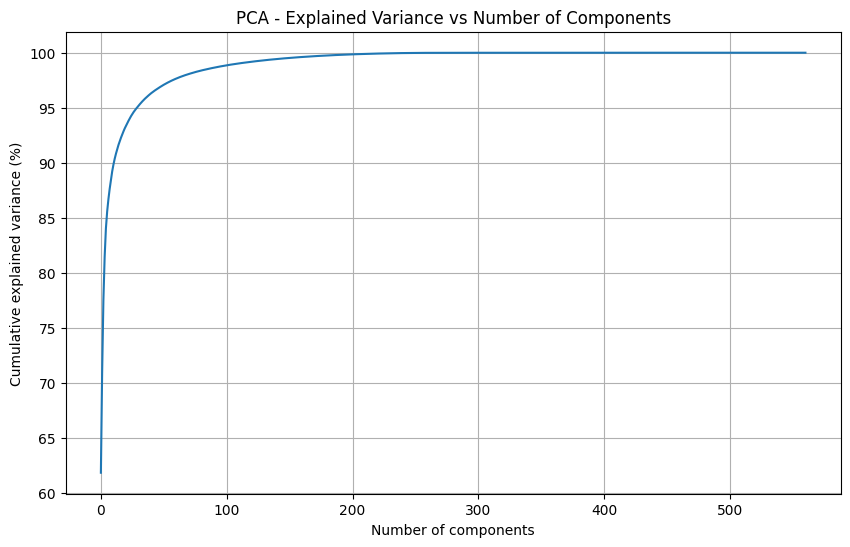

Number of components to capture 95.0% variance: 30


In [12]:
cumulative_variance = np.cumsum(pca_all.explained_variance_ratio_)
plt.figure(figsize=(10,6))
plt.plot(cumulative_variance*100)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance (%)')
plt.grid(True)
plt.title('PCA - Explained Variance vs Number of Components')
plt.show()

threshold = 0.95
n_components = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components to capture {threshold*100}% variance: {n_components}")

In [13]:
# Apply PCA
n_components = 30  
pca = PCA(n_components=n_components)
PCA_train_final = pca.fit_transform(PCA_train_scaled)
PCA_test_final = pca.transform(PCA_test_scaled)

In [14]:
print(f"PCA Train Shape: {PCA_train_final.shape}, PCA Test Shape: {PCA_test_final.shape}")

PCA Train Shape: (1896, 30), PCA Test Shape: (474, 30)


In [15]:
# Create LSTM Inputs
def processData(data, lookback, horizon, jump=1):
    X, Y = [], []
    for i in range(0, len(data) - lookback - horizon + 1, jump):
        X.append(data[i:(i+lookback)])
        Y.append(data[(i+lookback):(i+lookback+horizon)])
    return np.array(X), np.array(Y)

lookback = 252 
horizon = 22  

In [16]:
# Training data
X_PCA, _ = processData(PCA_train_final, lookback, horizon)
_, y = processData(array_train_scaled, lookback, horizon)
y = np.array([a.ravel() for a in y])

In [17]:
# Validation split
X_train, X_validate, y_train, y_validate = train_test_split(X_PCA, y, test_size=0.2, random_state=1)

In [18]:
# Test data
X_test, _ = processData(PCA_test_final, lookback, horizon)
_, y_test = processData(array_test_scaled, lookback, horizon)
y_test = np.array([a.ravel() for a in y_test])

In [19]:
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_validate: {X_validate.shape}, y_validate: {y_validate.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (1298, 252, 30), y_train: (1298, 1122)
X_validate: (325, 252, 30), y_validate: (325, 1122)
X_test: (201, 252, 30), y_test: (201, 1122)


 LSTM Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint(
    'models/lstm_model.h5',
    monitor='val_loss',
    save_best_only=True
)

num_neurons_L1 = 160
num_neurons_L2 = 80

model = Sequential([
    LSTM(num_neurons_L1, input_shape=(lookback, n_components), return_sequences=True),
    LSTM(num_neurons_L2),
    Dense(horizon * num_companies, activation='linear')
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_validate, y_validate),
    callbacks=[early_stopping, model_checkpoint],
    shuffle=False,
    verbose=2
)

Epoch 1/50


c:\Users\aicha\Downloads\projet github\Portfolio_Optimization_Model\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 12s - 1s/step - accuracy: 0.0039 - loss: 0.1892 - val_accuracy: 0.0031 - val_loss: 0.0694
Epoch 2/50
11/11 - 8s - 727ms/step - accuracy: 7.7042e-04 - loss: 0.0466 - val_accuracy: 0.0031 - val_loss: 0.0294
Epoch 3/50
11/11 - 13s - 1s/step - accuracy: 7.7042e-04 - loss: 0.0264 - val_accuracy: 0.0031 - val_loss: 0.0198
Epoch 4/50
11/11 - 11s - 983ms/step - accuracy: 0.0023 - loss: 0.0181 - val_accuracy: 0.0000e+00 - val_loss: 0.0152
Epoch 5/50
11/11 - 10s - 952ms/step - accuracy: 0.0077 - loss: 0.0154 - val_accuracy: 0.0000e+00 - val_loss: 0.0133
Epoch 6/50
11/11 - 9s - 815ms/step - accuracy: 0.0069 - loss: 0.0134 - val_accuracy: 0.0000e+00 - val_loss: 0.0115
Epoch 7/50
11/11 - 8s - 747ms/step - accuracy: 0.0031 - loss: 0.0113 - val_accuracy: 0.0000e+00 - val_loss: 0.0096
Epoch 8/50
11/11 - 6s - 529ms/step - accuracy: 0.0023 - loss: 0.0093 - val_accuracy: 0.0062 - val_loss: 0.0081
Epoch 9/50
11/11 - 6s - 528ms/step - accuracy: 0.0039 - loss: 0.0079 - val_accuracy: 0.0062 - val_los

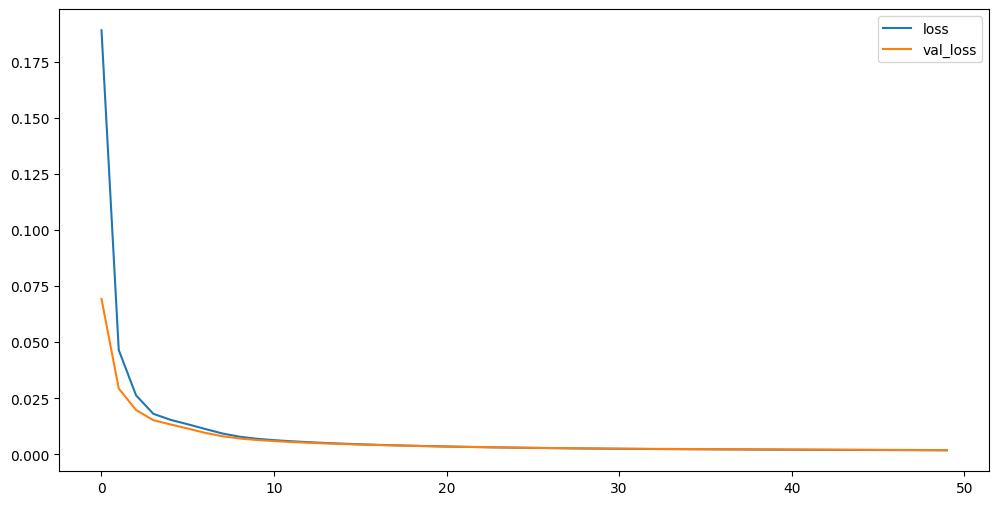

In [25]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()